In [1]:
# instalações das bibliotecas
!pip install yfinance ta scikit-learn xgboost matplotlib seaborn optuna

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#importações
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Coleta de dados

ticker = 'BTC-USD'
start_date = '2017-01-01' #~2017
end_date = '2019-12-31' #~2020

data = yf.download(ticker, start=start_date, end=end_date)
data.rename(columns={
    'Open': 'O',
    'High': 'H',
    'Low': 'L',
    'Close': 'C',
    'Volume': 'V'
}, inplace=True)

df_base = data[['O', 'H', 'L', 'C', 'V']].copy()

print("Dados do BTC-USD carregados:")
print(df_base.head())

C:\Users\alexi\AppData\Local\Temp\ipykernel_14372\3816047963.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Dados do BTC-USD carregados:
Price                 O            H            L            C          V
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD    BTC-USD
Date                                                                     
2017-01-01   963.658020  1003.080017   958.698975   998.325012  147775008
2017-01-02   998.617004  1031.390015   996.702026  1021.750000  222184992
2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  185168000
2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  344945984
2017-01-05  1156.729980  1191.099976   910.416992  1013.380005  510199008


In [4]:
# Função da Entropia de Boltzmann

def calculate_boltzmann_entropy(window_prices):

    TICK_SIZE_BTC = 0.001
    KB_RATIONALIZED = 1.3806

    max_price = window_prices.max()
    min_price = window_prices.min()

    if max_price == min_price:
        return 0.0

    # 1. Gap G
    G = (max_price - min_price) / TICK_SIZE_BTC

    # 2. Volume Gamma (Gamma = G^5)
    Gamma = np.power(max(1.0, G), 5)

    # 3. Entropia (S)
    entropy = KB_RATIONALIZED * np.log(Gamma)

    return entropy

In [5]:
# Formação da tabela base

print("Calculando features (X)...")
df_features = df_base.copy()

# Feature Principal (E)
df_features['E'] = df_features['C'].rolling(window=5).apply(calculate_boltzmann_entropy, raw=True)

# Feature básicas
df_features['M'] = ta.trend.macd(df_features['C'].squeeze())
df_features['R'] = ta.momentum.rsi(df_features['C'].squeeze())
df_features['SI'] = ta.momentum.stoch(df_features['H'].squeeze(), df_features['L'].squeeze(), df_features['C'].squeeze())
df_features['ADX'] = ta.trend.adx(df_features['H'].squeeze(), df_features['L'].squeeze(), df_features['C'].squeeze())

features_list = ['E', 'ADX', 'M', 'R', 'SI', 'V']
X = df_features[features_list]

print("Features (X) criadas.")
print(X.tail())

Calculando features (X)...
Features (X) criadas.
Price               E        ADX          M          R         SI            V
Ticker                                                                 BTC-USD
Date                                                                          
2019-12-26  86.396856  22.343450 -96.139127  46.191335  62.619891  22787010034
2019-12-27  80.537528  20.775785 -86.832677  47.746680  67.200157  22777360996
2019-12-28  78.234358  19.448511 -76.325964  48.619622  69.700039  21365673026
2019-12-29  83.671147  18.792289 -58.875243  51.867873  79.077341  22445257702
2019-12-30  83.671147  18.161343 -54.875149  47.833501  67.460588  22874131672


In [6]:
# Definição do Alvo Y para o XGBOOST

print("Calculando alvo (y)...")
df_target = df_base[['C']].copy()

# Definir "Risco": Usamos a Volatilidade Futura de 10 dias
df_target['Retornos'] = df_target['C'].pct_change()
df_target['Vol_Futura_10D'] = df_target['Retornos'].rolling(10).std().shift(-10)

# Definir "Risco Alto":
# Seja o quantil 0.75 (os 25% dias de maior volatilidade) como nosso limite
limite_risco = df_target['Vol_Futura_10D'].quantile(0.75)
print(f"O limite para 'Risco Alto' é uma volatilidade futura > {limite_risco:.4f}")

# Definir o label binário (0 ou 1)
df_target['Risco_Alto'] = np.where(df_target['Vol_Futura_10D'] > limite_risco, 1, 0)
y = df_target[['Risco_Alto']]

print("Alvo (y) criado.")
print(y.tail())

Calculando alvo (y)...
O limite para 'Risco Alto' é uma volatilidade futura > 0.0493
Alvo (y) criado.
Price      Risco_Alto
Ticker               
Date                 
2019-12-26          0
2019-12-27          0
2019-12-28          0
2019-12-29          0
2019-12-30          0


In [7]:
# Preparação e Divisão

# Juntar X e y
df_final = pd.concat([X, y], axis=1)

# Filtro de qualidade
df_final = df_final.dropna()
print(f"Total de amostras prontas: {len(df_final)}")

# Definir o alvo e as features
target_col = 'Risco_Alto'

# Divisão Cronológica (80/20) - SEMPRE FAÇA ISSO EM SÉRIES TEMPORAIS
split_index = int(len(df_final) * 0.8)

train_data = df_final.iloc[:split_index]
test_data = df_final.iloc[split_index:]

# Separar X e y finais
X_train = train_data[features_list]
y_train = train_data[target_col]

X_test = test_data[features_list]
y_test = test_data[target_col]

print(f"Amostras de Treino: {len(X_train)}")
print(f"Amostras de Teste: {len(X_test)}")
print(f"Distribuição do Alvo no Teste:\n{y_test.value_counts(normalize=True)}")

Total de amostras prontas: 1069
Amostras de Treino: 855
Amostras de Teste: 214
Distribuição do Alvo no Teste:
Risco_Alto
0    0.82243
1    0.17757
Name: proportion, dtype: float64


In [8]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

# Definir o Scorer: Queremos otimizar o F1-Score especificamente para a classe 1 (Risco Alto)
f1_risco_alto_scorer = make_scorer(f1_score, pos_label=1)

def objective_complex(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'seed': 42,

        # Parâmetros de Regularização e Desempenho
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # Fraction de amostras
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # Fraction de colunas
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = XGBClassifier(**param)

    score = cross_val_score(
        model, X_train, y_train,
        cv=3,
        scoring=f1_risco_alto_scorer,
        n_jobs=-1
    )

    return score.mean()


C:\Users\alexi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Execução da otimização do optuna

# Criar o Estudo
study = optuna.create_study(
    direction='maximize',  # Queremos o MAIOR F1-Score
    sampler=optuna.samplers.TPESampler(seed=42),  # <<< fixa a semente para reprodutibilidade
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

# Executar a otimização
N_TRIALS = 40
print(f"\nIniciando otimização com {N_TRIALS} trials (Maximizando F1-Score para Risco Alto)...")

study.optimize(
    objective_complex,
    n_trials=N_TRIALS,
    show_progress_bar=True
)

print("\nOtimização concluída!")
print(f"Melhor F1-Score (Risco Alto) obtido no CV: {study.best_value:.4f}")
print("Melhores hiperparâmetros:")
print(study.best_params)


[I 2025-11-16 00:07:34,724] A new study created in memory with name: no-name-ba0f095b-a676-4be0-b865-e81914986ad1



Iniciando otimização com 40 trials (Maximizando F1-Score para Risco Alto)...


Best trial: 0. Best value: 0.292716:   2%|▎         | 1/40 [00:06<04:10,  6.42s/it]

[I 2025-11-16 00:07:41,141] Trial 0 finished with value: 0.29271646950791336 and parameters: {'n_estimators': 144, 'max_depth': 9, 'learning_rate': 0.029106359131330698, 'gamma': 0.0006155564318973012, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'min_child_weight': 1}. Best is trial 0 with value: 0.29271646950791336.


Best trial: 0. Best value: 0.292716:   5%|▌         | 2/40 [00:10<03:11,  5.04s/it]

[I 2025-11-16 00:07:45,216] Trial 1 finished with value: 0.280823754789272 and parameters: {'n_estimators': 267, 'max_depth': 7, 'learning_rate': 0.02607024758370768, 'gamma': 1.4610865886287176e-08, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 3}. Best is trial 0 with value: 0.29271646950791336.


Best trial: 0. Best value: 0.292716:  10%|█         | 4/40 [00:14<01:37,  2.71s/it]

[I 2025-11-16 00:07:48,852] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.0040596116104843075, 'gamma': 0.00015777981883364995, 'subsample': 0.7727780074568463, 'colsample_bytree': 0.7164916560792167, 'min_child_weight': 7}. Best is trial 0 with value: 0.29271646950791336.
[I 2025-11-16 00:07:48,988] Trial 3 finished with value: 0.008771929824561403 and parameters: {'n_estimators': 85, 'max_depth': 5, 'learning_rate': 0.005404103854647328, 'gamma': 4.452048365748842e-05, 'subsample': 0.9140703845572055, 'colsample_bytree': 0.6798695128633439, 'min_child_weight': 6}. Best is trial 0 with value: 0.29271646950791336.


Best trial: 4. Best value: 0.314761:  15%|█▌        | 6/40 [00:14<00:42,  1.24s/it]

[I 2025-11-16 00:07:49,120] Trial 4 finished with value: 0.3147609573762585 and parameters: {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.016409286730647923, 'gamma': 2.3130924416844053e-07, 'subsample': 0.6260206371941118, 'colsample_bytree': 0.9795542149013333, 'min_child_weight': 10}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:49,317] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 252, 'max_depth': 5, 'learning_rate': 0.0015679933916723015, 'gamma': 0.0029775853025212607, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'min_child_weight': 5}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  20%|██        | 8/40 [00:14<00:21,  1.48it/s]

[I 2025-11-16 00:07:49,407] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 58, 'max_depth': 9, 'learning_rate': 0.0032927591344236173, 'gamma': 0.0019960815242513743, 'subsample': 0.7246844304357644, 'colsample_bytree': 0.8080272084711243, 'min_child_weight': 6}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:49,506] Trial 7 finished with value: 0.2717052767052767 and parameters: {'n_estimators': 96, 'max_depth': 9, 'learning_rate': 0.035503048581283086, 'gamma': 0.32808889626606236, 'subsample': 0.9579309401710595, 'colsample_bytree': 0.8391599915244341, 'min_child_weight': 10}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:49,584] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.0012315571723666018, 'gamma': 4.005370050283172e-06, 'subsample': 0.7554709158757928, 'colsample_bytree': 0.7085396127095583, 'min_child_weight': 9}. Best is trial 4 with value: 0.314760957376

Best trial: 4. Best value: 0.314761:  28%|██▊       | 11/40 [00:15<00:10,  2.72it/s]

[I 2025-11-16 00:07:49,692] Trial 9 finished with value: 0.26442773042137907 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.012172847081122434, 'gamma': 1.3408920002835378e-07, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'min_child_weight': 10}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:49,830] Trial 10 finished with value: 0.2780104145533238 and parameters: {'n_estimators': 210, 'max_depth': 3, 'learning_rate': 0.08691089486124963, 'gamma': 9.931221008063036e-07, 'subsample': 0.6058163500649457, 'colsample_bytree': 0.9630659181130071, 'min_child_weight': 8}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  30%|███       | 12/40 [00:15<00:09,  2.94it/s]

[I 2025-11-16 00:07:50,085] Trial 11 finished with value: 0.2794040551137 and parameters: {'n_estimators': 177, 'max_depth': 7, 'learning_rate': 0.019383199835819532, 'gamma': 0.04744042920726728, 'subsample': 0.6036910676177805, 'colsample_bytree': 0.8765521645266795, 'min_child_weight': 1}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  32%|███▎      | 13/40 [00:15<00:08,  3.26it/s]

[I 2025-11-16 00:07:50,297] Trial 12 finished with value: 0.27322230896001387 and parameters: {'n_estimators': 153, 'max_depth': 7, 'learning_rate': 0.06075771143646196, 'gamma': 6.142715235443227e-05, 'subsample': 0.6808646076666578, 'colsample_bytree': 0.7592025483615648, 'min_child_weight': 1}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  35%|███▌      | 14/40 [00:15<00:07,  3.40it/s]

[I 2025-11-16 00:07:50,552] Trial 13 finished with value: 0.2792362626093117 and parameters: {'n_estimators': 223, 'max_depth': 8, 'learning_rate': 0.010606069350717595, 'gamma': 0.0017638982178624831, 'subsample': 0.6652381501377056, 'colsample_bytree': 0.8940486940616845, 'min_child_weight': 4}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  38%|███▊      | 15/40 [00:16<00:07,  3.48it/s]

[I 2025-11-16 00:07:50,821] Trial 14 finished with value: 0.28738624338624336 and parameters: {'n_estimators': 187, 'max_depth': 6, 'learning_rate': 0.041680436203623536, 'gamma': 3.6526076024663067e-06, 'subsample': 0.8476671509616371, 'colsample_bytree': 0.9817673403517966, 'min_child_weight': 3}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  40%|████      | 16/40 [00:16<00:06,  3.66it/s]

[I 2025-11-16 00:07:51,057] Trial 15 finished with value: 0.2913323445803979 and parameters: {'n_estimators': 299, 'max_depth': 3, 'learning_rate': 0.017474018762964276, 'gamma': 1.6633721699077493e-08, 'subsample': 0.672477064560329, 'colsample_bytree': 0.7653656398770851, 'min_child_weight': 8}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  42%|████▎     | 17/40 [00:16<00:06,  3.53it/s]

[I 2025-11-16 00:07:51,369] Trial 16 finished with value: 0.13918447512678453 and parameters: {'n_estimators': 123, 'max_depth': 8, 'learning_rate': 0.0061245532725620775, 'gamma': 1.770259639076049e-07, 'subsample': 0.8358394007383037, 'colsample_bytree': 0.601402329355137, 'min_child_weight': 2}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  45%|████▌     | 18/40 [00:16<00:06,  3.57it/s]

[I 2025-11-16 00:07:51,638] Trial 17 finished with value: 0.2762057180961907 and parameters: {'n_estimators': 207, 'max_depth': 6, 'learning_rate': 0.04592040963310877, 'gamma': 0.023551319673305808, 'subsample': 0.6368527676416343, 'colsample_bytree': 0.8420937110721942, 'min_child_weight': 5}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  50%|█████     | 20/40 [00:17<00:04,  4.29it/s]

[I 2025-11-16 00:07:51,846] Trial 18 finished with value: 0.2869242312257833 and parameters: {'n_estimators': 163, 'max_depth': 5, 'learning_rate': 0.018140837457893834, 'gamma': 0.00036520883996116, 'subsample': 0.7238803118866866, 'colsample_bytree': 0.9266133003453951, 'min_child_weight': 7}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:52,021] Trial 19 finished with value: 0.2301685728721694 and parameters: {'n_estimators': 119, 'max_depth': 8, 'learning_rate': 0.0078035116692786715, 'gamma': 8.658203022702468e-06, 'subsample': 0.7177228092160637, 'colsample_bytree': 0.9993261174418501, 'min_child_weight': 4}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  55%|█████▌    | 22/40 [00:17<00:03,  4.78it/s]

[I 2025-11-16 00:07:52,205] Trial 20 finished with value: 0.2750387596899225 and parameters: {'n_estimators': 244, 'max_depth': 9, 'learning_rate': 0.09752124488451207, 'gamma': 1.428500669865978e-07, 'subsample': 0.8260215806250838, 'colsample_bytree': 0.7526481557504522, 'min_child_weight': 9}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:52,397] Trial 21 finished with value: 0.2828748298027295 and parameters: {'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.016076725019948467, 'gamma': 1.4345485379210972e-08, 'subsample': 0.6715587429520895, 'colsample_bytree': 0.7716111605400239, 'min_child_weight': 8}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  60%|██████    | 24/40 [00:18<00:03,  4.93it/s]

[I 2025-11-16 00:07:52,641] Trial 22 finished with value: 0.30810016191346445 and parameters: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.026233701832108085, 'gamma': 4.194142611380232e-08, 'subsample': 0.6401246211138735, 'colsample_bytree': 0.7137440747408894, 'min_child_weight': 9}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:52,800] Trial 23 finished with value: 0.2822468301962529 and parameters: {'n_estimators': 231, 'max_depth': 4, 'learning_rate': 0.028515075469995446, 'gamma': 6.504790133337491e-07, 'subsample': 0.6343361996622893, 'colsample_bytree': 0.6762425519556596, 'min_child_weight': 10}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  62%|██████▎   | 25/40 [00:18<00:02,  5.54it/s]

[I 2025-11-16 00:07:52,932] Trial 24 finished with value: 0.28018281780050464 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.061498103181203245, 'gamma': 1.3100585128219162e-05, 'subsample': 0.6328069311725487, 'colsample_bytree': 0.7189440754772674, 'min_child_weight': 9}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:53,131] Trial 25 finished with value: 0.2896070778037991 and parameters: {'n_estimators': 271, 'max_depth': 5, 'learning_rate': 0.026178108265172435, 'gamma': 6.299565004131495e-08, 'subsample': 0.6941466092321488, 'colsample_bytree': 0.6769032928581664, 'min_child_weight': 7}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  70%|███████   | 28/40 [00:18<00:01,  6.70it/s]

[I 2025-11-16 00:07:53,256] Trial 26 finished with value: 0.26793220159712305 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.01366265549269888, 'gamma': 0.0009339491463159093, 'subsample': 0.6388304184140785, 'colsample_bytree': 0.6445668591751237, 'min_child_weight': 9}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:53,363] Trial 27 finished with value: 0.14785856067949962 and parameters: {'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.008346988598876963, 'gamma': 5.99474657118274e-07, 'subsample': 0.6011121732807736, 'colsample_bytree': 0.8012364486139857, 'min_child_weight': 10}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  72%|███████▎  | 29/40 [00:18<00:01,  6.57it/s]

[I 2025-11-16 00:07:53,520] Trial 28 finished with value: 0.2924301987331104 and parameters: {'n_estimators': 158, 'max_depth': 6, 'learning_rate': 0.02473826622336007, 'gamma': 0.010700314287036147, 'subsample': 0.6939945257372604, 'colsample_bytree': 0.6126486621390769, 'min_child_weight': 2}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  78%|███████▊  | 31/40 [00:19<00:01,  5.82it/s]

[I 2025-11-16 00:07:53,750] Trial 29 finished with value: 0.284021164021164 and parameters: {'n_estimators': 261, 'max_depth': 7, 'learning_rate': 0.031791876455000166, 'gamma': 4.3931789462852037e-08, 'subsample': 0.6520376886350739, 'colsample_bytree': 0.73440923602106, 'min_child_weight': 3}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:53,914] Trial 30 finished with value: 0.28137566137566133 and parameters: {'n_estimators': 270, 'max_depth': 6, 'learning_rate': 0.050032409342468255, 'gamma': 2.1146815895974402e-05, 'subsample': 0.7518256572429263, 'colsample_bytree': 0.6933926237010336, 'min_child_weight': 8}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  82%|████████▎ | 33/40 [00:19<00:01,  5.69it/s]

[I 2025-11-16 00:07:54,152] Trial 31 finished with value: 0.29262510602205255 and parameters: {'n_estimators': 159, 'max_depth': 6, 'learning_rate': 0.024019702337710322, 'gamma': 0.01120301374817318, 'subsample': 0.6981681507773065, 'colsample_bytree': 0.613311919835147, 'min_child_weight': 2}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:54,291] Trial 32 finished with value: 0.2964733582915401 and parameters: {'n_estimators': 140, 'max_depth': 4, 'learning_rate': 0.021630767435929902, 'gamma': 0.27311148728061874, 'subsample': 0.6996143703138233, 'colsample_bytree': 0.6477186753187941, 'min_child_weight': 2}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  88%|████████▊ | 35/40 [00:19<00:00,  6.41it/s]

[I 2025-11-16 00:07:54,398] Trial 33 finished with value: 0.30434661076170505 and parameters: {'n_estimators': 106, 'max_depth': 4, 'learning_rate': 0.02177058134758817, 'gamma': 0.00010557957020799904, 'subsample': 0.6270807693319538, 'colsample_bytree': 0.6493915347941589, 'min_child_weight': 1}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:54,554] Trial 34 finished with value: 0.27214898086640543 and parameters: {'n_estimators': 92, 'max_depth': 4, 'learning_rate': 0.01312771643980701, 'gamma': 0.21724087443337498, 'subsample': 0.6215326255979686, 'colsample_bytree': 0.6588839360536616, 'min_child_weight': 1}. Best is trial 4 with value: 0.3147609573762585.


Best trial: 4. Best value: 0.314761:  92%|█████████▎| 37/40 [00:20<00:00,  7.44it/s]

[I 2025-11-16 00:07:54,680] Trial 35 finished with value: 0.2973643732086213 and parameters: {'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.021675554510682725, 'gamma': 0.00013290899375553508, 'subsample': 0.6510015215595216, 'colsample_bytree': 0.63587446568107, 'min_child_weight': 2}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:54,786] Trial 36 finished with value: 0.23548199767711964 and parameters: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.00916040402677623, 'gamma': 0.00024173900403338033, 'subsample': 0.6545545099721397, 'colsample_bytree': 0.6934560048696558, 'min_child_weight': 3}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:54,868] Trial 37 finished with value: 0.2919694166974966 and parameters: {'n_estimators': 66, 'max_depth': 3, 'learning_rate': 0.035333224231185685, 'gamma': 9.71189333631545e-05, 'subsample': 0.6247736736758526, 'colsample_bytree': 0.733007246236259, 'min_child_weight': 6}. Best is tr

Best trial: 4. Best value: 0.314761: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]

[I 2025-11-16 00:07:54,955] Trial 38 finished with value: 0.0 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.0020231866652905568, 'gamma': 2.271293840031643e-06, 'subsample': 0.8004021304815935, 'colsample_bytree': 0.6265075371862998, 'min_child_weight': 1}. Best is trial 4 with value: 0.3147609573762585.
[I 2025-11-16 00:07:55,066] Trial 39 finished with value: 0.0 and parameters: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.0038580641382437155, 'gamma': 2.1810560226099787e-05, 'subsample': 0.740801912419373, 'colsample_bytree': 0.8334412607113288, 'min_child_weight': 4}. Best is trial 4 with value: 0.3147609573762585.

Otimização concluída!
Melhor F1-Score (Risco Alto) obtido no CV: 0.3148
Melhores hiperparâmetros:
{'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.016409286730647923, 'gamma': 2.3130924416844053e-07, 'subsample': 0.6260206371941118, 'colsample_bytree': 0.9795542149013333, 'min_child_weight': 10}


Parametros fixados utilizados na análise dos resultados do projeto, dado:
ticker = 'BTC-USD'
start_date = '2017-01-01' 2019
end_date = '2019-12-31' 2020

In [10]:
# Fixar manualmente os hiperparâmetros otimizados para reprodutibilidade

fixed_params = {
    'n_estimators': 198,
    'max_depth': 3,
    'learning_rate': 0.016409286730647923,
    'gamma': 2.3130924416844053e-07,
    'subsample': 0.6260206371941118,
    'colsample_bytree': 0.9795542149013333,
    'min_child_weight': 10,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
    'seed': 42,
    'use_label_encoder': False
}
print("Parametros fixados para reprodutibilidade dos resultados do projeto")
print("\n Caso queria rodar o optuna, ignore esta celula")

Parametros fixados para reprodutibilidade dos resultados do projeto

 Caso queria rodar o optuna, ignore esta celula


C:\Users\alexi\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [00:07:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Treinando o Modelo Final Otimizado com Pesagem de Classes...
Calculando scale_pos_weight: 2.83

Parâmetros Otimizados Carregados do Optuna:
{'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.016409286730647923, 'gamma': 2.3130924416844053e-07, 'subsample': 0.6260206371941118, 'colsample_bytree': 0.9795542149013333, 'min_child_weight': 10}

--- RELATÓRIO DE CLASSIFICAÇÃO (FINAL PONDERADO) ---
                 precision    recall  f1-score   support

Risco Baixo (0)       0.90      0.68      0.78       176
 Risco Alto (1)       0.31      0.66      0.42        38

       accuracy                           0.68       214
      macro avg       0.61      0.67      0.60       214
   weighted avg       0.80      0.68      0.71       214


--- Matriz de Confusão FINAL (PONDERADA) ---


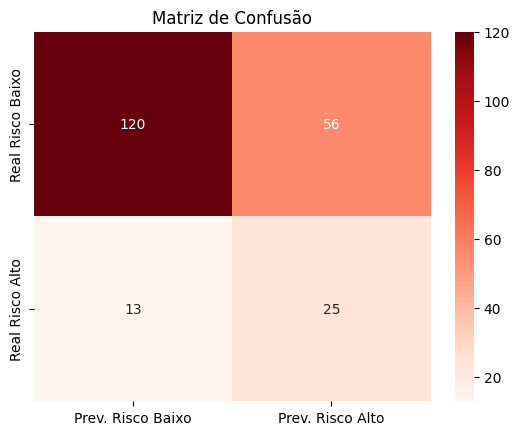

In [11]:
# Treinamento com Pesagem de Classes e parâmetros otimizados pelo Optuna

print("Treinando o Modelo Final Otimizado com Pesagem de Classes...")

# Calcular o peso (Classe 0 / Classe 1)
weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculando scale_pos_weight: {weight:.2f}")

# Carregar os melhores parâmetros do Optuna
final_params_weighted = study.best_params.copy()
print("\nParâmetros Otimizados Carregados do Optuna:")
print(final_params_weighted)

# Criar o modelo XGBoost usando os melhores parâmetros
model_weighted = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,   # fixa a semente para sklearn
    seed=42,           # fixa a semente para o XGBoost internamente
    use_label_encoder=False,
    scale_pos_weight=weight,   # <<< PONDERAÇÃO
    **final_params_weighted
)

# 4. Treinar
model_weighted.fit(X_train, y_train)

# 5. Avaliar
predictions_weighted = model_weighted.predict(X_test)

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO (FINAL PONDERADO) ---")
print(classification_report(y_test, predictions_weighted,
                            target_names=['Risco Baixo (0)', 'Risco Alto (1)']))

print("\n--- Matriz de Confusão FINAL (PONDERADA) ---")
cm_weighted = confusion_matrix(y_test, predictions_weighted)

sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Prev. Risco Baixo', 'Prev. Risco Alto'],
            yticklabels=['Real Risco Baixo', 'Real Risco Alto'])
plt.title('Matriz de Confusão')
plt.show()


--- AVALIANDO O VALOR CIENTÍFICO (FEATURE IMPORTANCE) ---

--- IMPORTÂNCIA DAS FEATURES (MODELO PONDERADO FINAL) ---
  Feature  Importance
0       E    0.291159
4      SI    0.155303
5       V    0.147292
2       M    0.143794
3       R    0.143233
1     ADX    0.119218


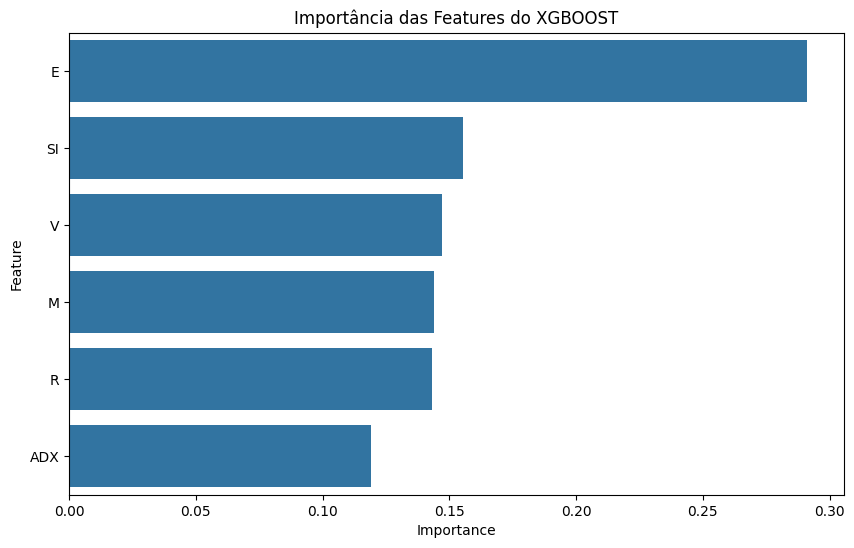

In [12]:
# Célula 19: Análise de Importância das Features (FINAL)

print("--- AVALIANDO O VALOR CIENTÍFICO (FEATURE IMPORTANCE) ---")

# 1. Extrair importâncias do modelo final PONDERADO
# (Requer 'model_weighted' da Célula 18 e 'features_list' da Célula 5)
importances_final = model_weighted.feature_importances_

# 2. Criar um DataFrame para visualização
df_importance_final = pd.DataFrame({
    'Feature': features_list,
    'Importance': importances_final
}).sort_values(by='Importance', ascending=False)

print("\n--- IMPORTÂNCIA DAS FEATURES (MODELO PONDERADO FINAL) ---")
print(df_importance_final)

# 3. Plotar o gráfico (O Gran Finale)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance_final)
plt.title('Importância das Features do XGBOOST')
plt.show()